# News summary bot

## Load data

In [5]:
from importlib.metadata import version
import tensorflow
import summa

import nltk
nltk.download('stopwords')  # NLTK 패키지에서 불용어 사전 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.2.0


In [6]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
data.sample(10)

,headlines,text
76107,'Les Twins' declared champions of World of Dance,French dancing duo comprising identical twins ...
22829,Son met Russian lawyer in 2016 for info on Hil...,US President Donald Trump has admitted his son...
3494,Dilip Kumar sends defamation notice to builder...,Veteran actor Dilip Kumar and his wife Saira B...
33777,Plea to stay Indu Malhotra's elevation unimagi...,The Supreme Court has refused a petition to st...
11378,Bollywood almost made me commit suicide: Aahan...,Actress Aahana Kumra has revealed she was so d...
49172,Working to raise share of exports in GDP to 20...,Commerce Minister Suresh Prabhu has said the g...
31807,Elon Musk dances with girlfriend Grimes at Met...,A video shows Elon Musk dancing with his girlf...
30828,"Cong gets 2% more votes, 25% less seats than B...",The Congress' vote share was almost 2% higher ...
8190,TN govt's shutdown of Sterlite Copper plant un...,The National Green Tribunal (NGT) on Wednesday...
87348,How is the President of India elected?,The President of India is elected indirectly w...


## Data Preprocessing

In [8]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [9]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [10]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [11]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [12]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [13]:
# 정규화 사전 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))  # 120

정규화 사전의 수:  120


In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [15]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [16]:
# 전체 text 데이터에 대한 전처리 : 시간이 다소 소요될 수 있습니다. 
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [17]:
# 전체 headlines 데이터에 대한 전처리 : 시간이 다소 소요될 수 있습니다. 
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [19]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [20]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## Data processing
### Make train, test set

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


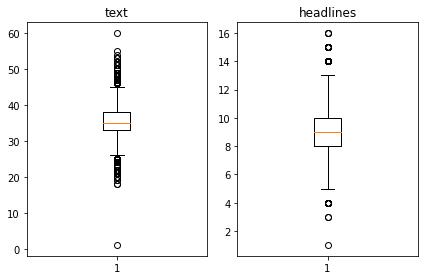

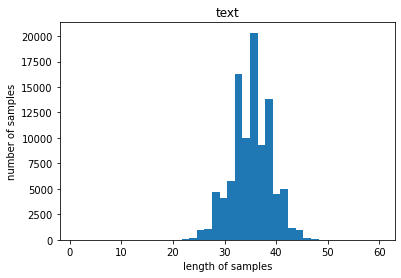

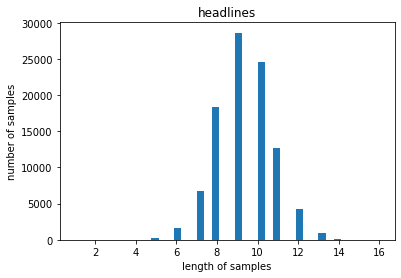

In [21]:
# 길이 분포 출력

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))  # 1
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))  # 60
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))  # 35.09968483123221
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))  # 1
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))  # 16
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))  # 9.299532330215534

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
text_max_len = 40  # text 최대 길이 설정
headlines_max_len = 11  # headlines 최대 길이 설정

In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])  
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [26]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


In [27]:
#헤드라인에 시작 토큰과 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [28]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [29]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 정수 시퀀스로 데이터의 샘플 순서를 정의 => 샘플이 섞이게 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 섞인 데이터를 8:2 비율로 train, test 분리할 예정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [30]:
# train, test 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


## Data processing
### Integer encoder

In [31]:
# 'text'
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [32]:
# 만들어진 단어 집합 중 희귀 단어(한계값 미만) 등장 빈도 비율 관련 내용 출력

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64630
등장 빈도가 6번 이하인 희귀 단어의 수: 44111
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20519
단어 집합에서 희귀 단어의 비율: 68.25158595079685
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.783002354179174


In [33]:
src_vocab = 20000  # 등장 빈도가 적은 단어를 제외한 단어 집합 크기

src_tokenizer = Tokenizer(num_words=src_vocab)  # 단어 집합 크기 설정해서 다시 생성
src_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[516, 2984, 8334, 944, 3650, 2159, 426, 1852, 15252, 1200, 1589, 1931, 39, 221, 158, 182, 2159, 944, 3650, 1563, 521, 7, 4796, 291, 1129, 4346, 138, 1300, 13888, 2984, 5586, 1173, 221, 182, 944, 3650, 2159, 521], [244, 696, 1246, 7116, 6651, 1025, 938, 2671, 285, 1191, 7359, 1679, 451, 182, 5657, 1736, 7603, 5122, 3430, 8891, 93, 1191, 1500, 4902, 11876, 1517, 451, 7247, 1026, 3275, 5122, 598, 1442, 714, 5657, 1300], [3138, 2416, 482, 298, 11010, 210, 998, 102, 1078, 163, 78, 197, 1406, 209, 15894, 10245, 421, 1015, 1104, 3402, 3138, 307, 16047, 197, 2852, 150, 352, 781, 35, 28, 190, 1046, 1521, 1948, 410, 25, 1849]]


In [35]:
# 'headlines'
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [36]:
# 만들어진 단어 집합 중 희귀 단어(한계값 미만) 등장 빈도 비율 관련 내용 출력

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28540
등장 빈도가 5번 이하인 희귀 단어의 수: 18846
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9694
단어 집합에서 희귀 단어의 비율: 66.03363700070078
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.199442793622316


In [37]:
tar_vocab = 10000  # 등장 빈도가 적은 단어를 제외한 단어 집합 크기

tar_tokenizer = Tokenizer(num_words=tar_vocab)  # 단어 집합 크기 설정해서 다시 생성
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 517, 2985, 32, 41, 3, 183, 3651, 2160, 4, 94, 160], [1, 6652, 348, 2672, 286, 5658, 153, 1301, 5], [1, 79, 1407, 15, 400, 422, 3, 1016, 1105, 3139, 299], [1, 510, 3, 228, 275, 5, 2673], [1, 344, 512, 3, 71, 17, 5955, 1513]]
target
decoder  [[517, 2985, 32, 41, 3, 183, 3651, 2160, 4, 94, 160, 2], [6652, 348, 2672, 286, 5658, 153, 1301, 5, 2], [79, 1407, 15, 400, 422, 3, 1016, 1105, 3139, 299, 2], [510, 3, 228, 275, 5, 2673, 2], [344, 512, 3, 71, 17, 5955, 1513, 2]]


In [39]:
# 길이 0인 샘플 인덱스 저장 => token 추가해놔서 실질적으로 길이 1인 샘플이다.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 길이 0인 샘플 인덱스(=token 추가로 인해 실질적으로 길이 1인 샘플 인덱스) 삭제
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

# 샘플 삭제 결과 확인
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


In [40]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Make model - encoder

In [41]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256  # LSTM의 capacity == LSTM의 용량 크기(뉴런 개수)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## Make model - decoder

In [42]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM: initial_state 인자값으로 인코더의 hidden state, cell state 값을 넣어야 함!
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [43]:
# 디코더의 출력층
# tar_vocab 의 여러 단어 중 하나를 선택해야 하는 다중 클래스 분류 문제라서 Dense(tar_vocab, activation='softmax') 사용
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [44]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## Train and visualize model

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 161s 566ms/step - loss: 6.0423 - val_loss: 5.5928
Epoch 2/50
269/269 [==============================] - 151s 560ms/step - loss: 5.4532 - val_loss: 5.2049
Epoch 3/50
269/269 [==============================] - 151s 562ms/step - loss: 5.1185 - val_loss: 4.9616
Epoch 4/50
269/269 [==============================] - 148s 552ms/step - loss: 4.8509 - val_loss: 4.7801
Epoch 5/50
269/269 [==============================] - 148s 550ms/step - loss: 4.6320 - val_loss: 4.6227
Epoch 6/50
269/269 [==============================] - 149s 553ms/step - loss: 4.4496 - val_loss: 4.4914
Epoch 7/50
269/269 [==============================] - 150s 557ms/step - loss: 4.2934 - val_loss: 4.3976
Epoch 8/50
269/269 [==============================] - 148s 550ms/step - loss: 4.1573 - val_loss: 4.3304
Epoch 9/50
269/269 [==============================] - 147s 548ms/step - loss: 4.0388 - val_loss: 4.2691
Epoch 10/50
269/269 [==============================] - 147s 547m

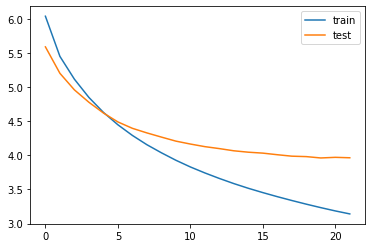

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Make inference model

In [47]:
# 사전 3개
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [48]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [49]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Test model

In [51]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [59]:
for i in range(15):
    print("* 원문 :", seq2text(encoder_input_test[i]))
    print("* 실제 요약 :", seq2summary(decoder_input_test[i]))
    print("* 추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

* 원문 : delhi police booked serving army major domestic help alleged raped multiple times woman claimed raped husband away returned major beat couple threatened woman husband allegedly committed suicide threatened army man 
* 실제 요약 : army major accused of rape by domestic help in delhi 
* 추상적 요약 :  cop rapes woman rapes her in delhi


* 원문 : mumbai could lose sq km area coastal caused metre rise sea level next years according study adding mangroves play significant role protecting city study claimed entire coastal belt mira worst affected 
* 실제 요약 : rising sea level could parts of mumbai in years 
* 추상적 요약 :  world highest rainfall in mumbai


* 원문 : centre informed supreme court taken conscious decision extend period beyond december demonetised notes non resident indians deadline ended march government responding court notice asking explain citizens granted one extension 
* 실제 요약 : no more extension for banned notes centre to sc 
* 추상적 요약 :  sc stays centre of india national notes


* 

## Abstractive Summarization by seq2seq

In [60]:
import requests
from summa.summarizer import summarize

text = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(text[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

In [62]:
for i in range(15):
    print("* 원문 :", text['text'][i])
    print("* 실제 요약 :", text['headlines'][i])
    print("* 추출적 요약 :", summarize(text['text'][i], ratio=0.4))
    print("\n")

* 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
* 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
* 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


* 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
* 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
* 추출적 요약 : Users get one CRED coin per rup

----------------------------------------------------------------------------------------------------------------------

# 회고

### 이번 프로젝트에는 Text Summarization으로 Abstractive Summarization, Extractive Summarization라는 두가지를 비교해보았다.


Extractive Summarization : 결과로 빈 리스트를 반환하는 문장도 꽤 있다. 단순 문장 추출이기 때문에 모델의 성능을 크게 고려하지 않아도 된다. 형식이 갖춰져있다. 


Abstractive Summarization : 모델의 성능이 뛰어나다는 전제하에 Extractive Summarization보다 성능이 좋은 것 같다.
좋은 결과를 내서 성능을 높이기 위해선 역시나 전처리를 더 잘해야하며 모델 학습을 잘 시켜야한다. 전처리와 모델 설계, 학습이 매우 중요한 덕목인 것 같다.